# Variational Principle (WORK IN PROGRESS)

The variational principle is a method for deducing upper bounds of energy eigenstates (usually used on the ground state). This notebook considers the application of the variational principle to simple molecular problems.

## Variational method

Consider a subset of Hilbert space (denoted by $H_s$) whose energy expectation values are greater than some eigenstate's energy that we want to find. It can be shown that the min energy expectation value of any superposition of these states is greater than or equal to the eigenenergy we want (see (Thijssen, 2013, p. 30) for the full proof or (Griffiths, 2018, p. 327) for the simple case).

## Different basis functions

The $H_c$ considered is usually defined by set of functions (called a basis) where the set of all normalised linear superpositions of these functions correspond to the subset.

For atomic systems, the most natural guess basis elements are Slater-type orbitals (STO). The simplest STO takes the form (Slater, 1930, p.57): $\psi_a = e^{-ar}$ (STOs in this form are enough for Hydrogen and Helium calculations). For these STOs, the general state in $H_c$ is:

$$\psi = \sum_i A_i e^{-a_i r}$$

The variational principle can then be applied by varying $A_i$ and $a_i$.

However, due to integrals involving STO being hard to calculate for more complex atoms (not actually true in cases considered in this notebook), most molecular calculations are done with Gaussian-type orbitals (GTO) (Goings, 2017). The simplest GTO takes the form: $\psi_a = e^{-\alpha r^2}$ (again this form is enough for Hydrogen and Helium calculations). The general state in $H_c$ is:

$$\psi = \sum_i d_i e^{-\alpha_i r^2}$$

$\alpha_i$ and $d_i$ can then be varied to apply the variational principle. GTOs will be considered in this notebook.

## Linear variational method

The variational problem for a set of GTOs turns out to be a non-linear problem if both $d_i$ s and $\alpha_i$ s are varied and a linear problem if only the $d_i$ s are varied. Because linear problems are easier we shall consider the linear problem first.

Given a set of $\alpha$ s, we can construct a set of kets $\{\ket{n}|n=1,2,3,...\}$. Then, a general ket in $H_c$ takes the form:

$$\ket{\phi} = \sum\limits_{i}C_i\ket{i}$$

$$\implies \bra{\phi}\hat{H}\ket{\phi} = \dfrac{\sum\limits_{i,j}C_i^{*}C_jH_{ij}}{\sum\limits_{i,j}C_i^{*}C_jS_{ij}}$$

where $H_{ij} = \bra{i}\hat{H}\ket{j}$ and $S_{ij} = \bra{i}\hat{S}\ket{j}$

Minimising $\bra{\phi}\hat{H}\ket{\phi}$ by calculus gives:

$\sum\limits_{j = 1}^{\infty}C_j(H_{ij} - E S_{ij})$ for all i

This can be rewritten as a matrix equation $\bf{H}\bf{C} = E \bf{S}\bf{C}$

## Linear variational method for the Hydrogen atom

Set up four simple GTOs with $ \alpha_1 = 13.00773, \alpha_2 = 1.962079, \alpha_3 = 0.444529, \alpha_4 = 0.1219492 $ (taken from (Ditchfield & et al, 1970, p. 5001)). 

For Hydrogen, the matrix elements are (Thijssen, 2013, p. 30):

$$S_{nm} = \left( \frac{\pi}{\alpha_n + \alpha_m} \right)^{\frac{3}{2}}$$

$$H_{nm} = 3\frac{\alpha_n\alpha_m\pi^{\frac{3}{2}}}{(\alpha_n + \alpha_m)^{\frac{5}{2}}} - \frac{2\pi}{\alpha_n + \alpha_m}$$

The following program implements this approach and considers a few simple applications.

In [22]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from scipy.special import erfc


In [23]:

#functions that calculate components 
def Sij(alpha_i,alpha_j):
    return (np.pi/(alpha_i + alpha_j))**1.5

def Hij(alpha_i,alpha_j):
    return 3*(alpha_i*alpha_j*(np.pi**1.5))/((alpha_i + alpha_j)**(5/2)) - 2*np.pi/(alpha_i + alpha_j)

#values of alpha
alphas_H = np.array([13.00773, 1.962079, 0.444529, 0.1219492])

def findHydrogenGroundState(alphas):
        
    #finding matrices as lists
    S = np.array([[Sij(a_i,a_j) for a_i in alphas] for a_j in alphas])
    H = np.array([[Hij(a_i,a_j) for a_i in alphas] for a_j in alphas])

    #find eigenvalues
    eigenvalues, eigenvectors = eigh(H,S)
    return eigenvalues[0], eigenvectors[0]


def findHydrogenGroundEnergy(alphas):
    
    eigenvalues, eigenvectors = findHydrogenGroundState(alphas) #better names
    
    return eigenvalues


In [24]:
#ground state calculation
groundEnergy = findHydrogenGroundEnergy(alphas_H)
print(f"Ground energy is {groundEnergy} hartree. The correct value is -0.5 hartree.")

Ground energy is -0.49927840566748466 hartree. The correct value is -0.5 hartree.


The following code graphs the density plot of the ground state deduced above.

Text(0, 0.5, 'y')

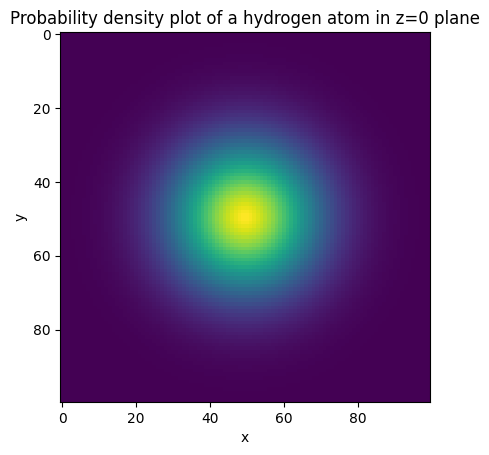

In [25]:
energy_H, states_H = findHydrogenGroundState(alphas_H)

def getProbDensity(contractionCoeff,alphas,halfWidth,N): 
    """
    Function finds the prob density for a GTO basis in the z=0 plane.
    """
    x = np.linspace(-halfWidth, halfWidth, N)
    y = np.linspace(-halfWidth, halfWidth, N)
    xv, yv = np.meshgrid(x, y)

    wavefunction = np.zeros((N,N))
    for i in range(alphas.shape[0]):
        wavefunction +=  contractionCoeff[i]*np.exp(-alphas[i]*(xv**2 + yv**2))

    return wavefunction**2

plt.imshow(getProbDensity(states_H,alphas_H,5,100))
plt.title("Probability density plot of a hydrogen atom in z=0 plane")
plt.xlabel("x")
plt.ylabel("y")

## Finding $\alpha_i$ s for the Hydrogen atom

As described in (Ditchfield & et al, 1970, p. 5001) and (Thijssen, 2013, p. 67), there are two common methods to deduce $\alpha_i$ s appropriate for the variational problem: fit a linear combination of GTOs to a previously found solution or consider the full variational problem with both $\alpha$ s and $d$ s being varied. Both these problems are considered in the simple case of hydrogen below.

### Full variational problem approach

To solve this problem, a slightly more efficient approach than in (Ditchfield & et al, 1970,p. 5001) is used. Ditchfield's approach varies both $\alpha$ s and $d$ s via the iterative Direct Search method (Hooke & Jeeves, 1961, p. 213). However, as the linear method gives an efficient solution to the problem if the $\alpha$ s are known, the energy function can be viewed as a function of $\alpha$ s only and the direct method (which is less efficient) can be applied only to the $\alpha$ s. This approach is implemented below.

Note that the Direct  Search method is written for a general function that is being minimised (as this method is used in other parts of the notebook).


In [26]:
def getNewAlphasByDirectSearch(alphas,delta,getEnergy,depth=0):
    """ 
    Function takes an intial guess of the alphas and applies the direct search method recursively to find the 
    alphas that minimise the ground state energy.

    Inputs:
    alphas - inital guess alpha array
    delta -  accuracy to which the direct search method will be applied 
    getEnergy - function of alphas that gets the energy of the system
    depth - depth of recursion
    """

    dim = alphas.shape[0]
    assert np.all(alphas > np.zeros(dim))
    assert np.unique(alphas).shape[0] == dim

    newAlphas = np.copy(alphas)
    for i in range(dim):
        alphasUp = np.copy(alphas)
        alphasUp[i] += delta

        alphasDown = np.copy(alphas)
        #as alphas have to be positive 
        if alphasDown[i] <= delta:
            alphasDown[i] /= 2
        else:
            alphasDown[i] -= delta

        E = getEnergy(alphas)
        EUp = getEnergy(alphasUp)
        EDown = getEnergy(alphasDown)

        if EUp-E >= 0 and EDown - E >= 0:
            pass
        elif EUp - E > 0:
            newAlphas[i] = alphasDown[i]
        elif EUp - E <= 0:
            newAlphas[i] = alphasUp[i]
    
    #1/10 factor means that no change is alphas has occured
    if np.allclose(newAlphas,alphas,rtol=delta/10):
        return newAlphas
    elif depth == 999:
        return newAlphas
    else:
        return getNewAlphasByDirectSearch(newAlphas,delta,getEnergy,depth+1)


def getNewAlphas(intialAlphas,deltaInital,n,getEnergy=findHydrogenGroundEnergy):
    """
    Function that takes an intial guess for the alphas and applies the direct search method recursively 
    for smaller and smaller deltas. Assumes deltaInital is less that 1.
    """
    alphas = np.copy(intialAlphas)
    delta = deltaInital
    for i in range(n):
        alphas = getNewAlphasByDirectSearch(alphas,delta,getEnergy)
        delta *= deltaInital
    return alphas

#application for some intial guess for different accuracies
intialAlphaGuess = np.array([17, 1, 1.5, 2])
for i in range(1,5):
    newAlphas = getNewAlphas(intialAlphaGuess,0.1,i)
    print(f"Energy found is  {findHydrogenGroundEnergy(newAlphas)}, the alpha accuracy used is {np.round(0.1**(i),i)}")

Energy found is  -0.4962408180680613, the alpha accuracy used is 0.1
Energy found is  -0.49915702949875584, the alpha accuracy used is 0.01
Energy found is  -0.49924121009263805, the alpha accuracy used is 0.001
Energy found is  -0.4992421104376131, the alpha accuracy used is 0.0001


### Fitting to previously found solution

Following the methods described in (Hehre & et al, 1969, p. 2658) and  (Stewart, 1969, p. 432), the STO basis solution (which turns out to be the exact solution) can be decomposed into a set of GTOs by minimising:

$$R = \lambda\left(\int dV \left(\sum_id_ie^{-\alpha_ir^2}\right)^2 - 1\right) + \int dV \left(\frac{1}{\sqrt{\pi}}e^{-r} - \sum_id_ie^{-\alpha_ir^2}\right)^2$$

This can be done efficiently by recursively minimising $R$ for the alpha terms by Direct Search method (Hooke & Jeeves, 1961, p. 213) and finding the associated $d_i$ s by solving the matrix problem formed from $\frac{\partial R}{\partial d_i} = 0$. 

In [27]:
def getResidual(ds,alphas): 
    n = ds.shape[0]
    residual = np.sqrt(np.pi/8)
    residual -= np.sqrt(np.pi)*np.sum((-2/alphas**2 + (1 + 2*alphas)*np.exp(1/(4*alphas))*np.sqrt(np.pi)*erfc(1/(2*np.sqrt(alphas)))/alphas**2.5)*ds)

    S = np.array([[(np.pi/(alphas[i] + alphas[j]))**1.5 for i in range(n)] for j in range(n)])
    residual += np.einsum('ij,i,j', S, ds, ds) 

    return residual


def leastSquaresOnDs(alphas):
    N = alphas.shape[0]

    C = np.sqrt(np.pi)*(-2/alphas**2 + (1 + 2*alphas)*np.exp(1/(4*alphas))*np.sqrt(np.pi)*erfc(1/(2*np.sqrt(alphas)))/alphas**2.5)

    M = np.empty((N,N))
    for i in range(N):
        M[i,i] = (np.pi/(2*alphas[i]))**1.5
        for j in range(i):
            M[i,j] = (np.pi/(alphas[i] + alphas[j]))**1.5
            M[j,i] = M[i,j]
    
    newDs = np.linalg.inv(M) @ C

    S = np.array([[Sij(a_i,a_j) for a_i in alphas] for a_j in alphas])
    newDs /= np.sqrt(np.einsum('ij,i,j', S, newDs, newDs))

    return newDs

def expandHinGuassian(alphas,ds,deltaAlphas,deltaDs,depth=0):
    newAlphas = getNewAlphas(alphas,deltaAlphas,10,getEnergy=lambda a: getResidual(ds,a))
    newDs = leastSquaresOnDs(newAlphas)
    if np.allclose(newAlphas,alphas,rtol=deltaAlphas/10) and np.allclose(newDs,ds,rtol=deltaDs/10): 
        return newAlphas,newDs
    elif depth == 999:
        return newAlphas,newDs
    else:
        return expandHinGuassian(newAlphas,newDs,deltaAlphas,deltaDs,depth+1)


In [28]:
def getEnergy(alphas,ds):        
    #finding matrices as lists
    S = np.array([[Sij(a_i,a_j) for a_i in alphas] for a_j in alphas])
    H = np.array([[Hij(a_i,a_j) for a_i in alphas] for a_j in alphas])

    return np.einsum('ij,i,j', H, ds, ds)/np.einsum('ij,i,j', S, ds, ds) 

alphasInit = np.array([12, 0.1, 0.5, 1.9])
dsInit = np.array([-0.1, 0.2, 0.1, -0.3])

a,d = expandHinGuassian(alphasInit,dsInit,0.1,0.1)

print(f"Energy is: {getEnergy(a,d)}")

Energy is: -0.48839114276738915


## Helium atom 

Via the Born-Oppenheimer, the Helium atom Hamiltonian is:

$\hat{H} = -\frac{1}{2}\nabla_1^2 -\frac{1}{2}\nabla_2^2 + \frac{1}{|\vec{r_1} - \vec{r_2}|}  - \frac{2}{r_1} - \frac{2}{r_2}$

As the ground state energy is in a singlet spin state, the position part of the wavefunction is $\psi (\vec{r_1},\vec{r_2}) = \phi (\vec{r_1})\phi (\vec{r_2})$. Assuming that $\phi (\vec{r})$ is normalised, it can be shown that (Thijssen, 2013, p. 46):

$(-\frac{1}{2}\nabla_1^2 - \frac{2}{r_1} + \int dV_2 \frac{|\phi{\vec{r_2}}|^2}{|\vec{r_1} - \vec{r_2}|})\phi(\vec{r_1}) = E\phi(\vec{r_1})$

This equation cannot be solved exactly. However, we can get an upper bound using the linear variational method described above. Using the same $\psi_{\alpha_n}(\vec{r})$ with different values of $\alpha$, this can be reformulated into a matrix problem:

$\sum\limits_{q}(h_{pq} + \sum\limits_{r,s}C_s C_r Q_{prqs})C_q = E\sum\limits_{q} S_{pq}C_q$

where

$h_{pq} = \bra{\psi_{\alpha_p}}-\frac{1}{2}\nabla^2 - \frac{2}{r}\ket{\psi_{\alpha_p}}$

$Q_{prqs} = \int dV_1 dV_2 \frac{\psi_{\alpha_p}(\vec{r_1})\psi_{\alpha_r}(\vec{r_2})\psi_{\alpha_q}(\vec{r_1})\psi_{\alpha_s}(\vec{r_2})}{|\vec{r_1}-\vec{r_2}|}$

$S_{pq} = \bra{\psi_{\alpha_p}}\ket{\psi_{\alpha_q}}$

This can be solved by guessing the $C$ values, plugging them into the $Q$ part of the expression and solving the eigenvalue equation produced. The process can then be repeated recursively with the $C$ s found until the error is below some specified value (works because the ground state energy is a stable fixed point under this map).

The ground state energy can then be deduced from:

$E_G = 2\sum\limits_{p,q}C_p C_q h_{pq} +\sum\limits_{p,q,r,s} Q_{prqs}C_p C_q C_s C_r$

This process is implemented below.

In [29]:
#simulation parameters
alphas2 = [0.298073, 1.242567, 5.782948, 38.47497]


In [30]:
#functions to calculate matrix elements 

def Qijkl(alpha_i,alpha_j,alpha_k,alpha_l):
    """
    Calculates the components of the Q matrix.
    """
    denominator = (alpha_i + alpha_k)*(alpha_j + alpha_l)*((alpha_i + alpha_j + alpha_k + alpha_l)**0.5)
    return 2*(np.pi**2.5)/denominator

def hij(alpha_i,alpha_j):
    """
    Finds components of h matrix
    """
    return (3*alpha_i*alpha_j*(np.pi**1.5))/((alpha_i + alpha_j)**2.5) -  4*np.pi/(alpha_i + alpha_j)



In [31]:
#find matricies
h = np.zeros((4, 4))
S2 = np.zeros((4, 4))
Q = np.zeros((4, 4, 4, 4))

for i in range(4):
    for j in range(4):
        h[i,j] = hij(alphas2[i],alphas2[j])
        S2[i,j] = Sij(alphas2[i], alphas2[j])
        for k in range(4):
            for l in range(4):
                Q[i, j, k, l]= Qijkl(alphas2[i],alphas2[j],alphas2[k],alphas2[l])



In [32]:

#normalisation function 
def normalise(C):
    """
    Normalises C (remember that the set doesn't have to be orthonomal so this is not trivial)
    """
    innerProduct = 0
    for i,c_i in enumerate(C):
        for j,c_j in enumerate(C):
            innerProduct += c_i*c_j*S2[i][j]

    return C/(innerProduct**0.5)  



In [33]:
#intial guess
CGuess = normalise(np.array([1, 1, 1, 1])) 
EGuess = 0

#run simulation
def iterateC(C,EPrev):
    """
    Performs one iteration of the recursive cycle   
    """
    #finds F matrix
    F = h + np.einsum('ikjl,k,l', Q, C, C) 

    #finds new C values
    eigenvalues, eignestates = eigh(F,S2,eigvals_only=False)
    CNew = normalise(eignestates[:,0])

    #find E
    groundEnergyFound =  2*np.einsum('ij,i,j', h, CNew, CNew) + np.einsum('ikjl,i,j,k,l', Q, CNew, CNew, CNew, CNew)
    
    #iterates agian if difference between previous iteration is not less than max error
    if abs(groundEnergyFound - EPrev) < 1E-14:
        return groundEnergyFound 
    else:
        return iterateC(CNew,groundEnergyFound)

print(f"Ground energy is {iterateC(CGuess,EGuess)} hartree. The correct value is -2.903 hartree.")

Ground energy is -2.8551603823702516 hartree. The correct value is -2.903 hartree.


In [34]:
#look at Kopmann theorm for Helium, should be able to get hydrogen specra as well
#look at Generalized X-Ray Scattering Factors ROBERT F. STEWART
#and using Hartree-Fock approximation to calculate cross-sections due to molecules (Born approx)


## References

Thijseen J., 2013. Computational Physics. Cambridge: Cambridge University Press

Griffiths D., 2018. Introduction To Quantum Mechanics.  Cambridge: Cambridge University Press

Ditchfield, R., Hehre, W., & J.Pople. (1970). Self-Consistent Molecular Orbital Methods. VI. Energy Optimized. The Journal of Chemical Physics, 5001-5006.

Hooke, R., & Jeeves, T. (1961). "Direct Search" Solution of Numerical and Statistical Problems. Journal of the ACM, 212 - 229.

Slater J., 1930. Atomic Shielding Constants. Physical Review: Volume 36

Goings, J., 2017. joshuagoings. [Online] 
Available at: https://joshuagoings.com/2017/04/28/integrals/
[Accessed 17 June 2024].

Hehre, W., Stewart, R., & Pople, J. (1969). Self-Consistent Molecular-Orbital Methods. I. Use of Gaussian Expansions of Slater-Type Atomic Orbitals. The Journal of Chemical Physics, 2657-2664.

Stewart, R. (1969). Small Gaussian Expansions of Slater-Type Orbitals . Tth Journal of Chemical Physics , 431-438.